# AI & DL

## Курсовой проект
## Выполнил: Инютин М. А.
## Группа: М8О-407Б-19

Необходимые библиотеки для анализы данных

In [1]:
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y

### Выбор задачи, датасета, описание

Я выбрал набор данных [Политическая кухня](https://disk.yandex.ru/d/9XuZIF8IIAx2fw) из олимпиады студентов "Я - профессионал"

***Описание***

*Задача предоставлена партнером олимпиады — Федеральным исследовательским центром "Информатика и управление" РАН*

На некотором несуществующем интернет-ресурсе "Политическая кухня" популярностью пользуются два вида видеороликов: про политику и про кулинарию. При этом под роликами про консервативную политику комментарии оставляют только консерваторы, про либеральную - только либералы. Кулинарные видео комментируют только кулинары. Иногда на ресурсе "Политическая кухня" происходит сбой, и комментарии перепутываются (кулинарный комментарий попадает под политическое видео, либеральный --- под консервативное видео и т.п.), тогда необходимо по комментарию определить, кто его оставил (консерватор, либерал или кулинар) и перенести в соответствующий раздел. Доступа к самим текстам комментариев у команды "Политической кухни" нет, но все тексты прошли обработку лингвистическим анализатором и каждый представлен набором численных признаков.

Перед вами стоит задача разработать алгоритм машинного обучения, предсказывающий кем был написан комментарий: консерватором, либералом или кулинаром.

***Формат ввода***

Тренировочная выборка `Train.csv` представляет собой csv-таблицу со столбцами-признаками и столбцом целевой переменной target.

Описание признаков обучающих данных:

* `comments_count` - общее количество комментариев под видео, для которого создан комментарий,

* `replies_count` - общее количество ответов на комментарии под видео,

* `both_count` - общее количество сообщений под видео,

* `sentence_count` - общее количество предложений под видео,

* `word_count` - общее количество слов под видео,

* `target` - метка кем был оставлен комментарий (0 - либерал, 1 - кулинар, 2 - консерватор),

* остальные столбцы - признаки, полученные с помощью лингвистического анализатора.

### Предпроцессинг данных

Функция для отрисовки гистограммы

In [3]:
PLT_SZ = 5


def gist(ds, n, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(cols * PLT_SZ, rows * PLT_SZ))
    fig.suptitle("Распределения числовых признаков")
    for i in range(n):
        sns.histplot(ds[ds.columns[i]], ax=ax[i // cols][i % cols], kde=True)
    pass

In [4]:
ds = pd.read_csv("../data/yaprof/Train.csv")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   comments_count                               3381 non-null   int64
 1   replies_count                                3381 non-null   int64
 2   both_count                                   3381 non-null   int64
 3   sentence_count                               3381 non-null   int64
 4   word_count                                   3381 non-null   int64
 5   basic_emotions                               3381 non-null   int64
 6   basic emotions_fear                          3381 non-null   int64
 7   basic_emotions_anger                         3381 non-null   int64
 8   basic_emotions_sadness                       3381 non-null   int64
 9   basic_emotions_joy                           3381 non-null   int64
 10  basic_emotions_surprise_

In [5]:
ds = ds.rename(
    columns={
        "basic_emotions": "BE",
        "basic emotions_fear": "BE_fear",
        "basic_emotions_anger": "BE_anger",
        "basic_emotions_sadness": "BE_sadness",
        "basic_emotions_joy": "BE_joy",
        "basic_emotions_surprise_interest": "BE_interest",
        "basic_emotions_disgust": "BE_disgust",
        "emotions_of_social_evaluation": "EoCE",
        "emotions_of_social_evaluation_contempt": "EoCE_contempt",
        "emotions_of_social_evaluation_shame": "EoCE_shame",
        "emotions_of_social_evaluation_guilt": "EoCE_guilt",
        "emotions_of_social_evaluation_embarrassment": "EoCE_embarr",
        "emotions_of_social_evaluation_pride": "EoCE_pride",
        "emotions_of_social_evaluation_envy": "EoCE_envy",
    }
)
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   comments_count           3381 non-null   int64
 1   replies_count            3381 non-null   int64
 2   both_count               3381 non-null   int64
 3   sentence_count           3381 non-null   int64
 4   word_count               3381 non-null   int64
 5   BE                       3381 non-null   int64
 6   BE_fear                  3381 non-null   int64
 7   BE_anger                 3381 non-null   int64
 8   BE_sadness               3381 non-null   int64
 9   BE_joy                   3381 non-null   int64
 10  BE_interest              3381 non-null   int64
 11  BE_disgust               3381 non-null   int64
 12  EoCE                     3381 non-null   int64
 13  EoCE_contempt            3381 non-null   int64
 14  EoCE_shame               3381 non-null   int64
 15  EoCE

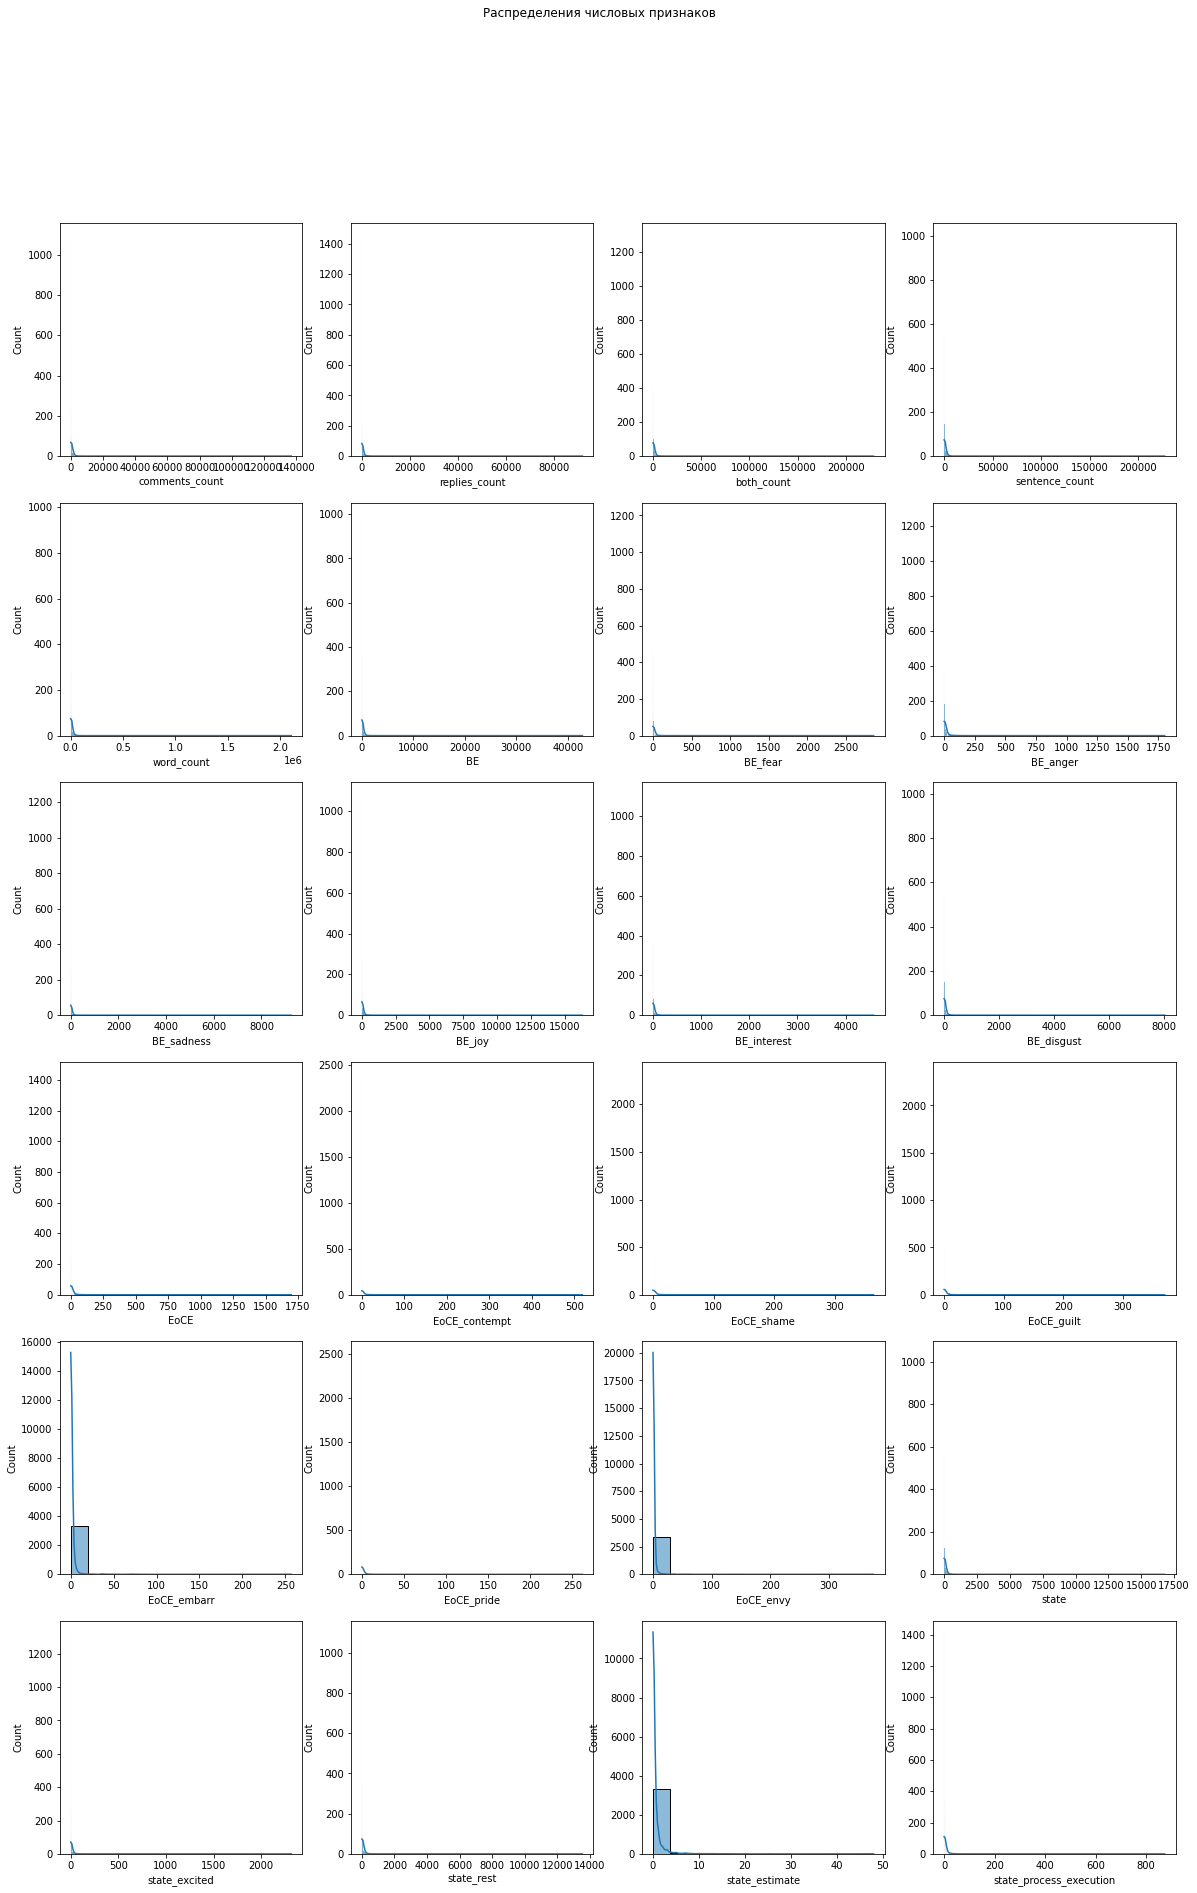

In [6]:
gist(ds, 24, 6, 4)

In [7]:
ds.describe()

,comments_count,replies_count,both_count,sentence_count,word_count,BE,BE_fear,BE_anger,BE_sadness,BE_joy,...,EoCE_guilt,EoCE_embarr,EoCE_pride,EoCE_envy,state,state_excited,state_rest,state_estimate,state_process_execution,target
count,3381.000000,3381.000000,3381.000000,3381.000000,3.381000e+03,3381.000000,3381.000000,3381.000000,3381.000000,3381.00000,...,3381.000000,3381.000000,3381.000000,3381.000000,3381.000000,3381.000000,3381.000000,3381.000000,3381.000000,3381.000000
mean,716.322094,389.283644,1105.605738,1175.560485,1.065012e+04,193.550133,14.044957,12.559006,34.935226,68.86572,...,2.174209,1.125702,1.572612,1.073943,94.000887,11.471162,76.454599,0.419403,5.655723,1.432121
std,4299.374831,2296.896085,6520.227387,6664.666222,5.977782e+04,1119.565542,98.824360,66.774307,231.774475,400.77136,...,14.517021,7.772497,9.579771,8.893710,521.524465,66.381813,431.285580,1.879135,26.564209,0.598240
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,6.000000,45.000000,69.000000,6.230000e+02,11.000000,0.000000,0.000000,1.000000,3.00000,...,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,4.000000,0.000000,0.000000,1.000000
50%,107.000000,53.000000,172.000000,203.000000,2.003000e+03,34.000000,2.000000,2.000000,5.000000,10.00000,...,0.000000,0.000000,0.000000,0.000000,16.000000,2.000000,12.000000,0.000000,1.000000,1.000000
75%,408.000000,250.000000,691.000000,702.000000,6.342000e+03,112.000000,6.000000,7.000000,17.000000,37.00000,...,1.000000,0.000000,1.000000,0.000000,56.000000,6.000000,45.000000,0.000000,4.000000,2.000000
max,136877.000000,91912.000000,228789.000000,227434.000000,2.107711e+06,42833.000000,2856.000000,1801.000000,9254.000000,16315.00000,...,370.000000,257.000000,262.000000,376.000000,16778.000000,2317.000000,13539.000000,48.000000,874.000000,2.000000


Удаляю выбросы

In [8]:
COEF_OUTLIERS = 3

col_val = dict()

for col in ds:
    col_np = ds[col].to_numpy()
    mu = np.mean(col_np)
    sigma = np.std(col_np)
    col_val[col] = (mu - COEF_OUTLIERS * sigma, mu + COEF_OUTLIERS * sigma)

In [9]:
for key in col_val.keys():
    l, r = col_val[key]
    ds = ds.loc[l <= ds[key]]
    ds = ds.loc[ds[key] <= r]

In [10]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3309 entries, 0 to 3380
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   comments_count           3309 non-null   int64
 1   replies_count            3309 non-null   int64
 2   both_count               3309 non-null   int64
 3   sentence_count           3309 non-null   int64
 4   word_count               3309 non-null   int64
 5   BE                       3309 non-null   int64
 6   BE_fear                  3309 non-null   int64
 7   BE_anger                 3309 non-null   int64
 8   BE_sadness               3309 non-null   int64
 9   BE_joy                   3309 non-null   int64
 10  BE_interest              3309 non-null   int64
 11  BE_disgust               3309 non-null   int64
 12  EoCE                     3309 non-null   int64
 13  EoCE_contempt            3309 non-null   int64
 14  EoCE_shame               3309 non-null   int64
 15  EoCE

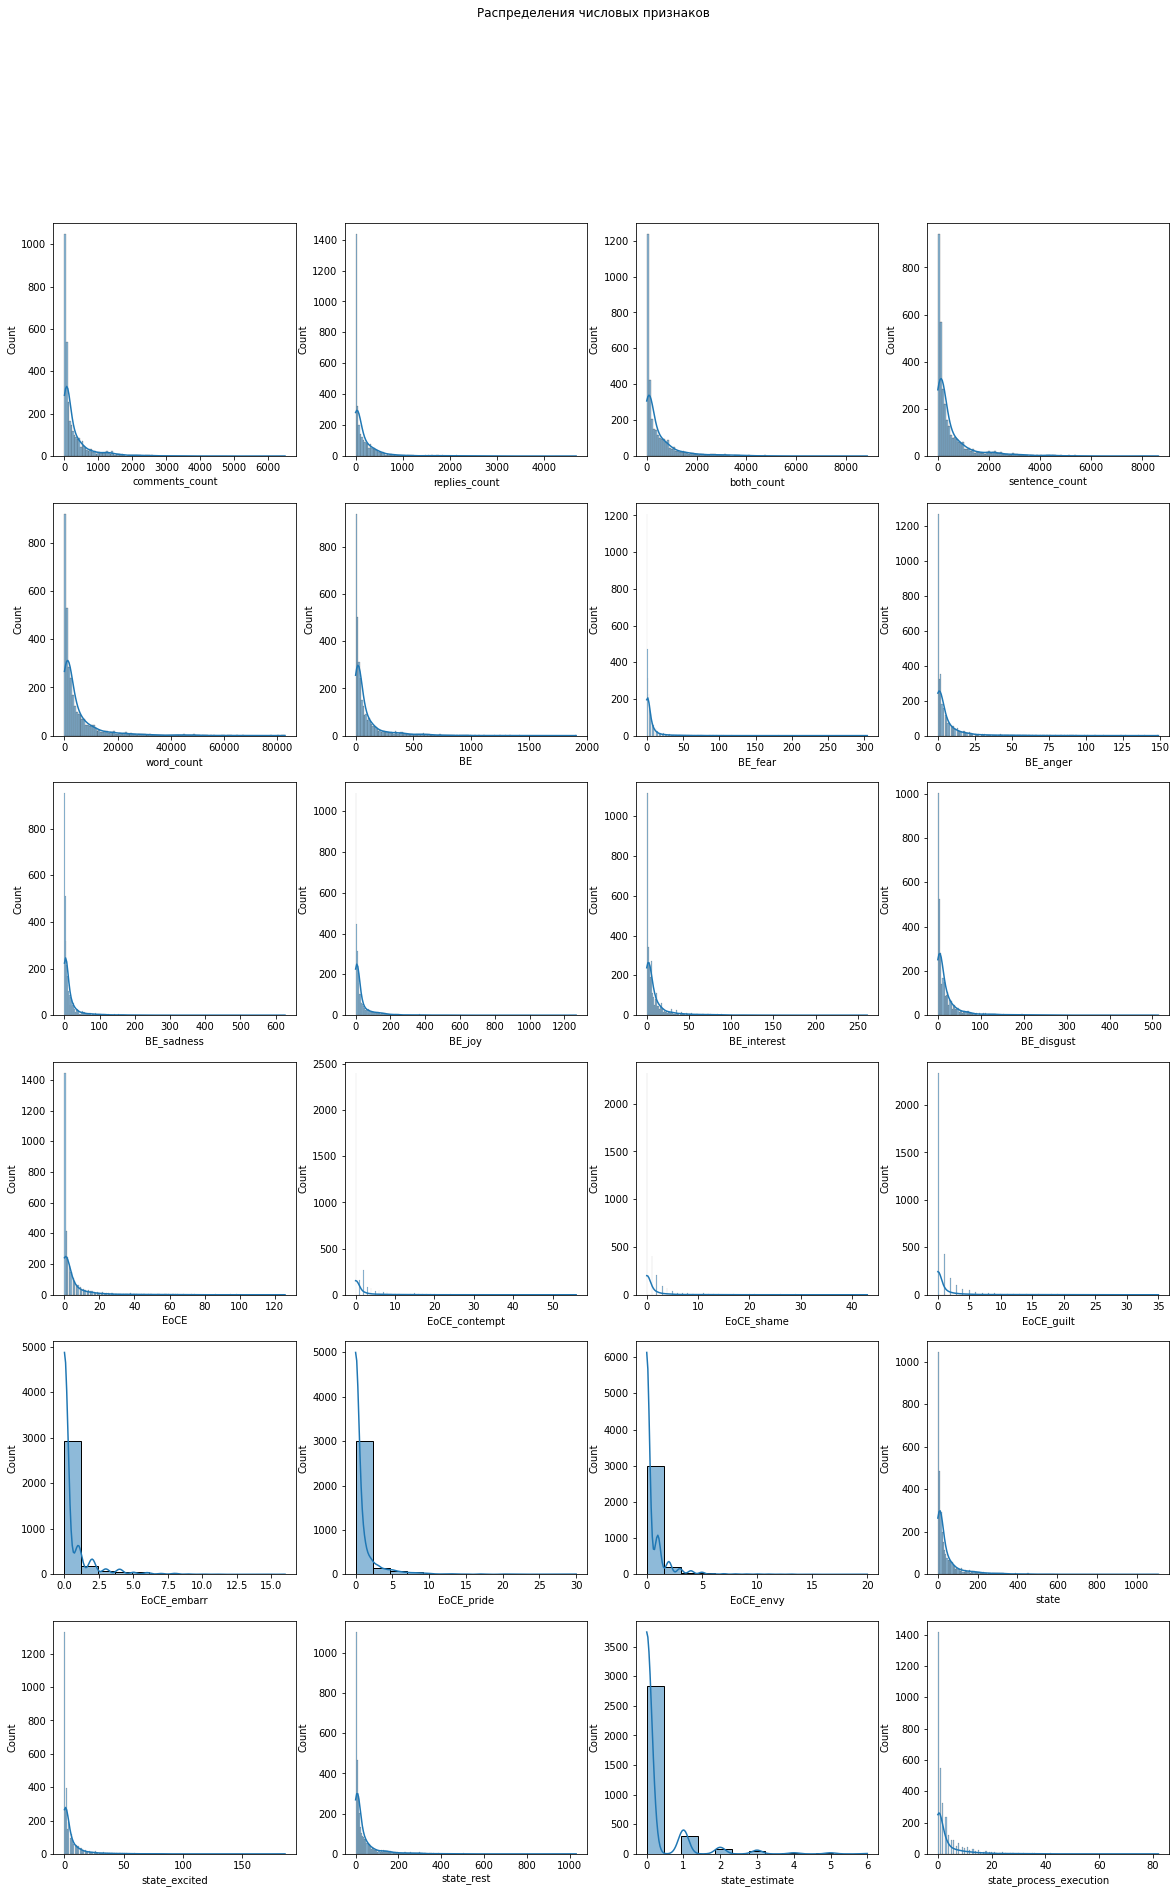

In [11]:
gist(ds, 24, 6, 4)

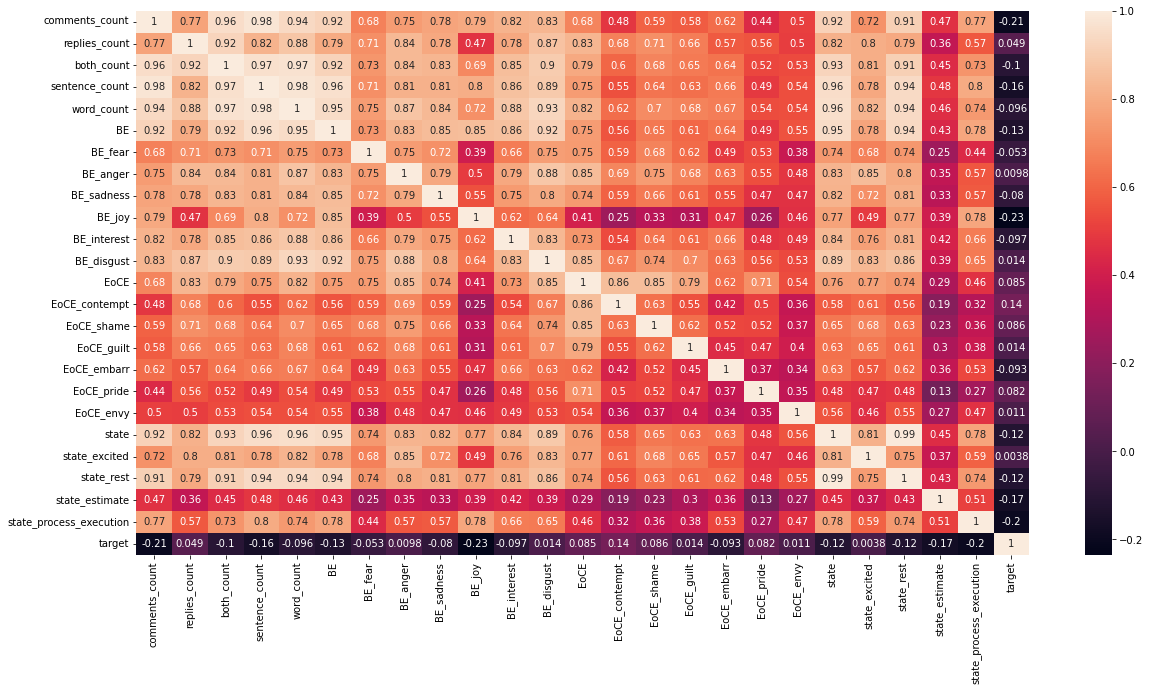

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(ds.corr(), annot=True, ax=ax)
pass

Удаляю столбцы с коэффициентом корреляции $R \ge 0.9$: `both_count`, `sentence_count`, `word_cound`,`BE`, `state`, `state_rest`

In [13]:
ds = ds.drop("both_count", axis="columns")
ds = ds.drop("sentence_count", axis="columns")
ds = ds.drop("word_count", axis="columns")
ds = ds.drop("BE", axis="columns")
ds = ds.drop("state", axis="columns")
ds = ds.drop("state_rest", axis="columns")

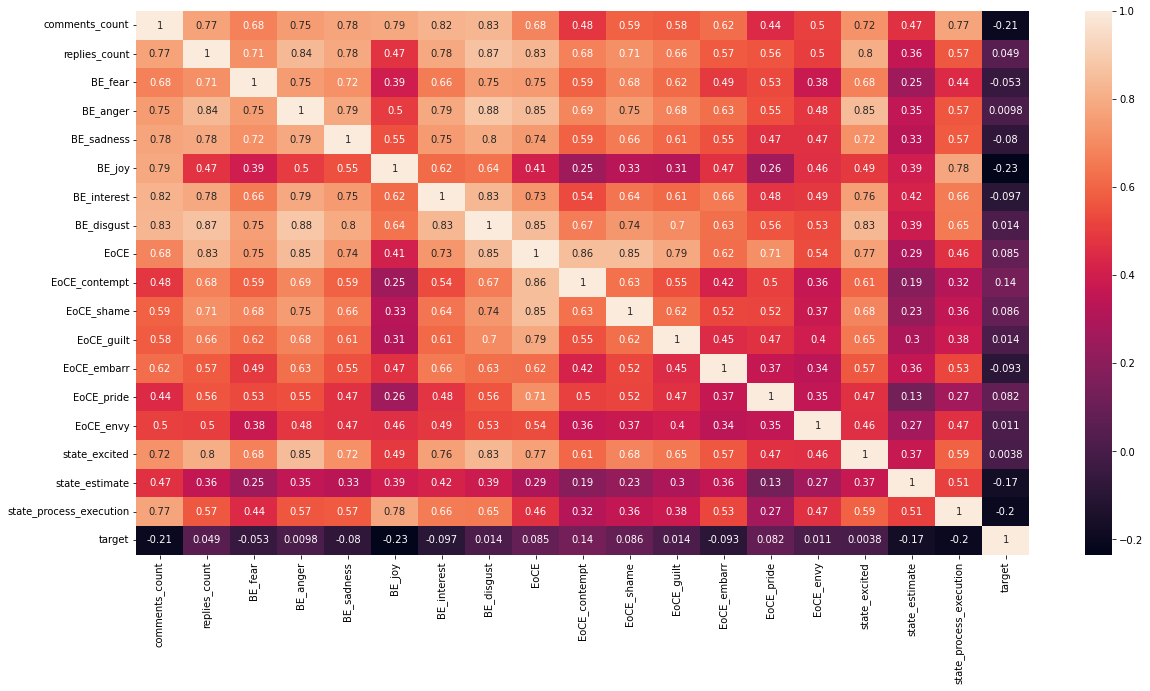

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(ds.corr(), annot=True, ax=ax)
pass

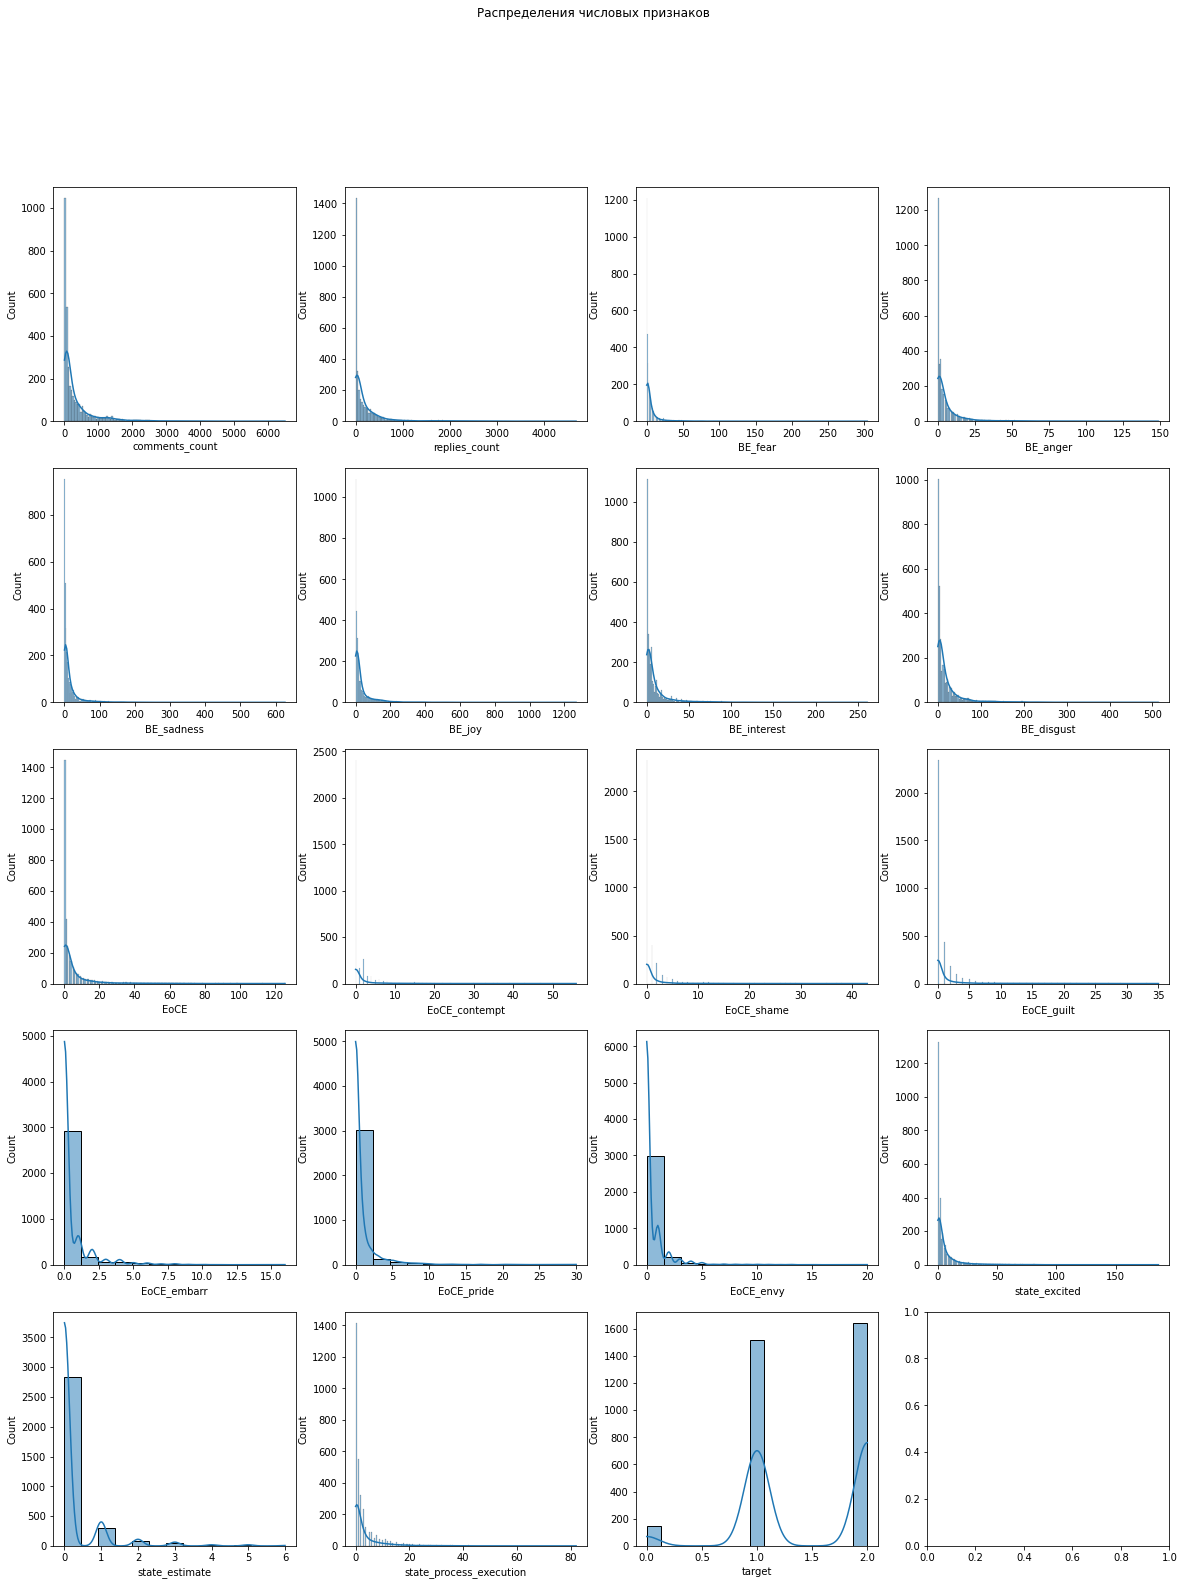

In [15]:
gist(ds, 19, 5, 4)

Есть сильный перевес классов, использую `downsampling`

In [16]:
COEF_UNDER = 1
CLASSES = 2

ds_0 = ds[ds["target"] == 0]
ds_other = ds[ds["target"] != 0]
down_ds_other = ds_other.sample(n=len(ds_0) * CLASSES * COEF_UNDER, random_state=1)
ds = pd.concat([down_ds_other, ds_0])
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447 entries, 1585 to 3380
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   comments_count           447 non-null    int64
 1   replies_count            447 non-null    int64
 2   BE_fear                  447 non-null    int64
 3   BE_anger                 447 non-null    int64
 4   BE_sadness               447 non-null    int64
 5   BE_joy                   447 non-null    int64
 6   BE_interest              447 non-null    int64
 7   BE_disgust               447 non-null    int64
 8   EoCE                     447 non-null    int64
 9   EoCE_contempt            447 non-null    int64
 10  EoCE_shame               447 non-null    int64
 11  EoCE_guilt               447 non-null    int64
 12  EoCE_embarr              447 non-null    int64
 13  EoCE_pride               447 non-null    int64
 14  EoCE_envy                447 non-null    int64
 15  st

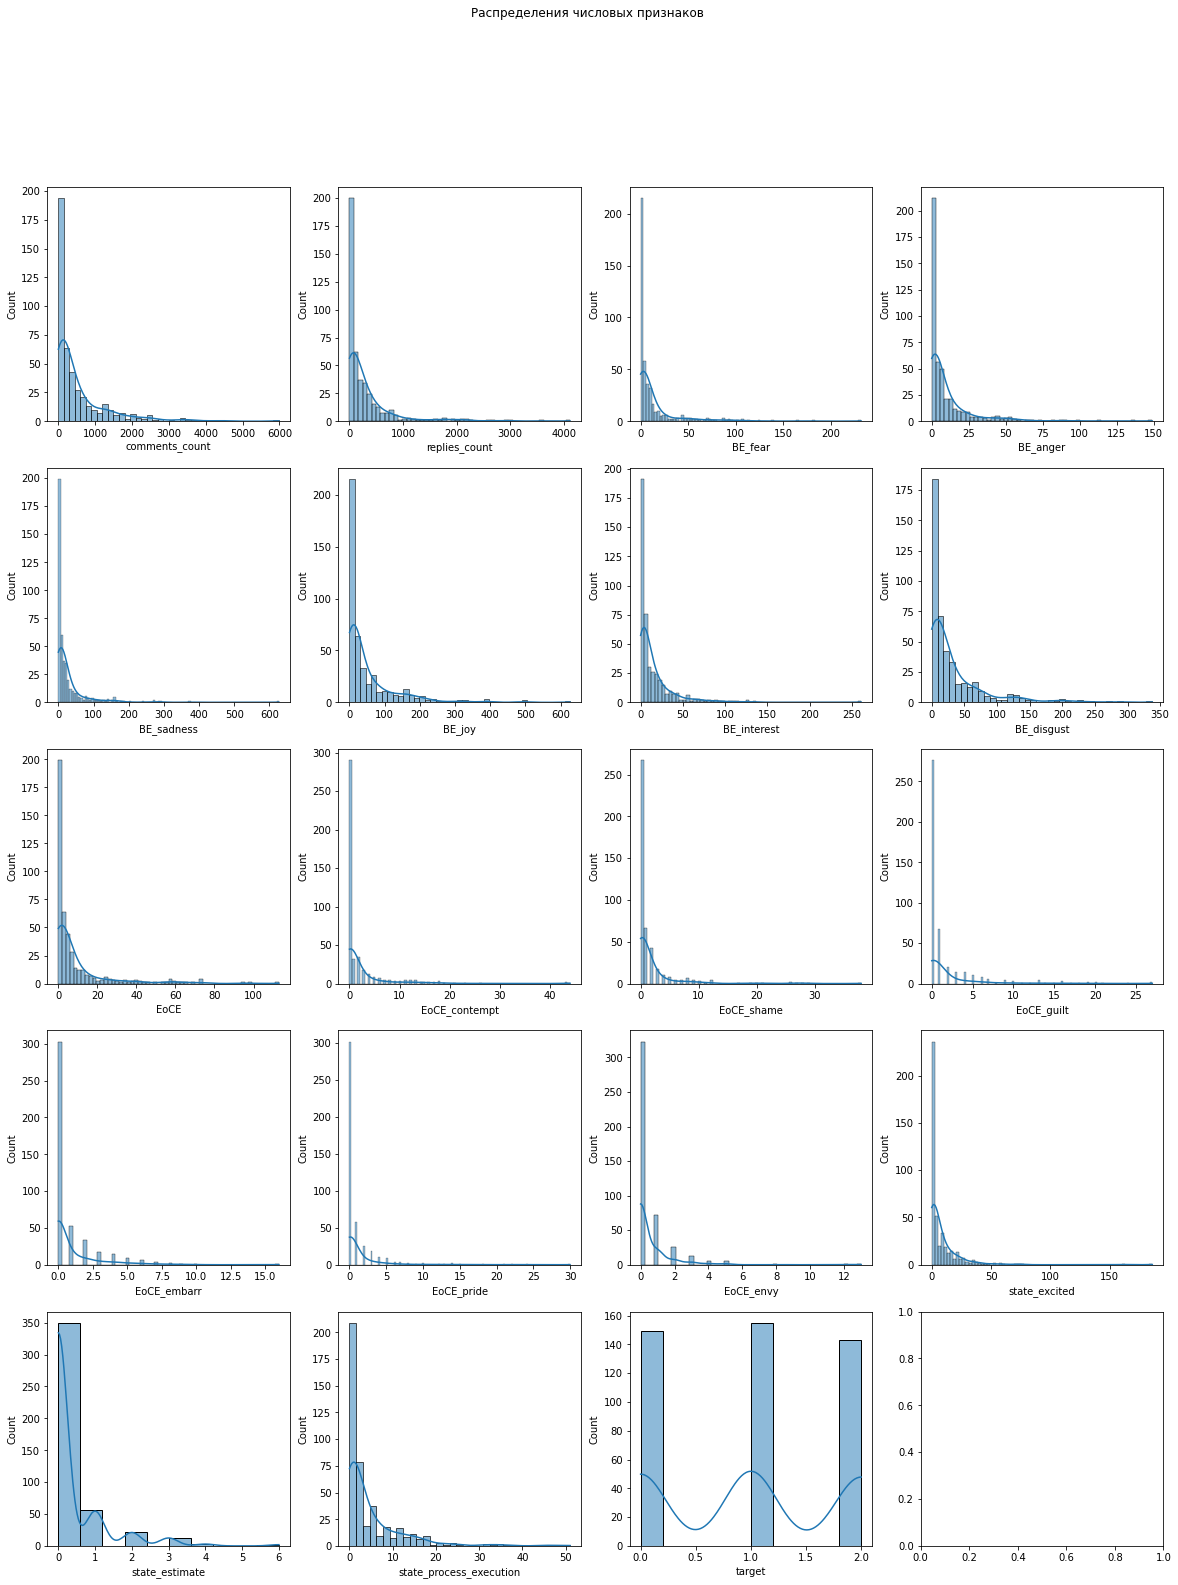

In [17]:
gist(ds, 19, 5, 4)

In [18]:
X = ds.drop("target", axis=1).to_numpy()
y = ds["target"].to_numpy()

print("Размерность входных данных:", X.shape)
print("Размерность выходных данных:", y.shape)

Размерность входных данных: (447, 18)
Размерность выходных данных: (447,)


In [19]:
X[:5]

array([[ 432,  236,    8,    5,   10,   37,    7,   18,    3,    1,    0,
           2,    0,    0,    0,    2,    0,    2],
       [  37,   14,    1,    0,    1,    5,    0,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    2],
       [1018,  270,    2,    6,   18,  126,   17,   28,    0,    0,    0,
           0,    0,    0,    0,    6,    1,   34],
       [ 153,  300,    8,    9,   15,   16,    6,   11,    8,    7,    1,
           0,    0,    0,    0,    4,    0,    1],
       [2498, 2953,   43,   88,   99,  178,   93,  204,   58,   18,   12,
           6,    6,   14,    2,   74,    0,   17]])

Нормализую все признаки, чтобы они были в промежутке $[0, 1]$

In [20]:
X = normalize(X, norm="max", axis=0)

In [21]:
X[:5]

array([[0.07214429, 0.05732329, 0.03448276, 0.03355705, 0.01594896,
        0.05901116, 0.02681992, 0.05325444, 0.02654867, 0.02272727,
        0.        , 0.07407407, 0.        , 0.        , 0.        ,
        0.01075269, 0.        , 0.03921569],
       [0.00617902, 0.00340053, 0.00431034, 0.        , 0.0015949 ,
        0.00797448, 0.        , 0.00295858, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.03921569],
       [0.17000668, 0.06558173, 0.00862069, 0.04026846, 0.02870813,
        0.20095694, 0.0651341 , 0.08284024, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03225806, 0.16666667, 0.66666667],
       [0.0255511 , 0.07286859, 0.03448276, 0.06040268, 0.02392344,
        0.02551834, 0.02298851, 0.03254438, 0.07079646, 0.15909091,
        0.02631579, 0.        , 0.        , 0.        , 0.        ,
        0.02150538, 0.        , 0.01960784],
    

In [22]:
train_X, test_X, train_y, test_y = train_test_split(
    X, y, train_size=0.8, random_state=1, shuffle=True
)

print("Размерность тренировочных входных данных:", train_X.shape)
print("Размерность тренировочных выходных данных:", train_y.shape)

print("Размерность тестовых входных данных:", test_X.shape)
print("Размерность тестовых выходных данных:", test_y.shape)

Размерность тренировочных входных данных: (357, 18)
Размерность тренировочных выходных данных: (357,)
Размерность тестовых входных данных: (90, 18)
Размерность тестовых выходных данных: (90,)


### Реализация решающего дерево для классификации

Хранение данных в вершине дерева. Хранится предикат $X_{ind} > value$, если вершина не лист, иначе значение $value$

In [23]:
class TreeData:
    def __init__(self, value=None, ind=None, leaf=True):
        self.value = value
        self.ind = ind
        self.leaf = leaf

    def is_leaf(self):
        return self.leaf

    def decide(self, X):
        if self.is_leaf():
            return None
        else:
            return True if X[self.ind] > self.value else False

    def predict(self, X):
        if self.is_leaf():
            return value
        else:
            return None

Класс для хранения дерева. Реализован как список смежности

In [24]:
class Graph:
    def __init__(self):
        self.data = []
        self.info = []
        self.size = 0
        self.add()

    def can_go(self, u, c):
        return c in self.data[u]

    def go(self, u, c):
        return self.data[u][c]

    def set_go(self, u, c, v):
        self.data[u][c] = v

    def get_tree_data(self, u):
        return self.info[u]

    def set_tree_data(self, u, tree_data):
        self.info[u] = tree_data

    def add(self):
        self.data.append(dict())
        self.info.append(TreeData())
        self.size += 1
        return self.size - 1

    def is_leaf(self, u):
        return self.info[u].is_leaf()

Решающее дерево

В качестве критериев использую эти [формулы](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation)

In [25]:
EPS = 1e-9


def leq(x, y):
    return x < y or abs(x - y) < EPS


class DecisionTree:
    def __init__(self, classes, max_depth, min_samples_split, splitter, criterion):
        self.tree = Graph()
        self.classes = classes
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.splitter = splitter
        self.criterion = criterion
        self.data = []
        self.INF = 1e18

    def decide(self, X):
        return self.decide_rec(0, X)

    def decide_rec(self, u, X):
        u_data = self.tree.get_tree_data(u)
        if self.tree.is_leaf(u):
            return u_data.value
        else:
            dec = u_data.decide(X)
            return self.decide_rec(self.tree.go(u, dec), X)

    def make_leaf(self, u, value):
        u_data = TreeData(value=value, leaf=True)
        self.tree.set_tree_data(u, u_data)

    def rnd_ids(self, n):
        res = set()
        while len(res) * len(res) < n:
            rnd_num = randint(0, n - 1)
            while rnd_num in res:
                rnd_num = randint(0, n - 1)
            res.add(rnd_num)
        return np.array([elem for elem in res])
    
    def get_split_ids(self):
        if self.splitter == "random":
            return self.rnd_ids(self.d)
        if self.splitter == "best":
            return range(self.d)

    def build(self, X, y):
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.d = X.shape[1]
        ids = np.arange(self.n)
        self.build_rec(0, ids, 1)

    def calc_cnt(self, ids):
        cnt = np.zeros(self.classes)
        for j in ids:
            cnt[self.y[j]] += 1
        uniq = 0
        for el in cnt:
            if (el < 1):
                uniq += 1        
        return cnt, uniq

    def calc_p(self, cnt):
        n = 0
        for el in cnt:
            n += el
        return cnt / n

    def entropy(self, cnt, p):
        res = 0
        for i, elem in enumerate(p):
            if elem > 0:
                res += elem * np.log(elem)
        return -res
    
    def gini(self, cnt, p):
        res = 0
        for elem in p:
            res += elem * (1 - elem)
        return res

    def log_loss(self, cnt, p):
        res = 0
        for i, elem in enumerate(p):
            if 0 < elem < 1:
                res += elem * np.log(elem) + (1 - elem) * np.log(1 - elem)
        return -res

    def crit(self, cnt, p):
        if self.criterion == "entropy":
            return self.entropy(cnt, p)
        if self.criterion == "gini":
            return self.gini(cnt, p)
        if self.criterion == "log_loss":
            return self.log_loss(cnt, p)

    def build_rec(self, u, ids, h):
        n = len(ids)
        cnt, uniq = self.calc_cnt(ids)
        p = self.calc_p(cnt)
        stop1 = n < self.min_samples_split
        stop2 = False if self.max_depth == None else h > self.max_depth
        stop3 = uniq == 1
        if stop1 or stop2 or stop3:
            self.make_leaf(u, p)
            return
        u_data = self.tree.get_tree_data(u)
        split_ids = self.get_split_ids()
        loss = self.INF
        res = (-1, -1)
        for i in split_ids:
            tmp = sorted([(self.X[j][i], self.y[j]) for j in ids])
            size_l, size_r = 0, n
            cnt_l, cnt_r = np.zeros(self.classes), [el for el in cnt]
            for j in range(self.n):
                while size_l < n and leq(tmp[size_l][0], tmp[j][0]):
                    elem_y = tmp[size_l][1]
                    cnt_l[elem_y] += 1
                    cnt_r[elem_y] -= 1
                    size_l += 1
                size_r = n - size_l
                if size_l == 0 or size_r == 0:
                    continue
                p_l, p_r = self.calc_p(cnt_l), self.calc_p(cnt_r)
                loss_l = self.crit(cnt_l, p_l)
                loss_r = self.crit(cnt_r, p_r)
                split_loss = (size_l * loss_l + size_r * loss_r) / n
                if split_loss < loss:
                    loss = split_loss
                    res = (i, tmp[j][0])
        if res == (-1, -1):
            self.make_leaf(u, p)
            return
        u_data = TreeData(value=res[1], ind=res[0], leaf=False)
        self.tree.set_tree_data(u, u_data)
        l, r = [], []
        for j in ids:
            if u_data.decide(self.X[j]):
                l.append(j)
            else:
                r.append(j)
        ul = self.tree.add()
        ur = self.tree.add()
        self.tree.set_go(u, True, ul)
        self.tree.set_go(u, False, ur)
        self.build_rec(ul, np.array(l), h + 1)
        self.build_rec(ur, np.array(r), h + 1)

Классификатор

In [26]:
class MyDecisionTreeClassifier(ClassifierMixin, BaseEstimator):
    def __init__(
        self,
        classes=2,
        max_depth=None,
        min_samples_split=2,
        splitter="best",
        criterion="gini",
    ):
        self.classes = classes
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.splitter = splitter
        self.criterion = criterion
        self.tree = DecisionTree(
            classes, max_depth, min_samples_split, splitter, criterion
        )

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.tree.build(X, y)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ["X_", "y_"])

        # Input validation
        X = check_array(X)

        p = []
        for elem in X:
            z = self.tree.decide(elem)
            p.append(np.argmax(z))
        return np.array(p)

### Выбор метрики качества

Я выбрал `accuracy` в качестве метрики качества

In [27]:
def scores(model, X, y):
    print("Лучшие гиперпараметры модели:", model.best_params_)
    print("Лучший счёт модели:", model.best_score_)
    pred = model.best_estimator_.predict(X)
    print("Метрика Accuracy:", accuracy_score(y, pred))

    figure = plt.figure(figsize=(20, 10))
    ax = plt.subplot(1, 1, 1)
    matr = confusion_matrix(y, pred)
    ConfusionMatrixDisplay(matr).plot(ax=ax)
    plt.show()

### Демонстрация результатов

In [28]:
params = {
    "dtc__max_depth": [None, 32, 16, 8],
    "dtc__min_samples_split": [2, 4, 8],
    "dtc__splitter": ["best", "random"],
    "dtc__criterion": ["gini", "entropy", "log_loss"],
}

Лучшие гиперпараметры модели: {'dtc__criterion': 'gini', 'dtc__max_depth': None, 'dtc__min_samples_split': 2, 'dtc__splitter': 'best'}
Лучший счёт модели: 0.5377565752306823
Метрика Accuracy: 0.6222222222222222


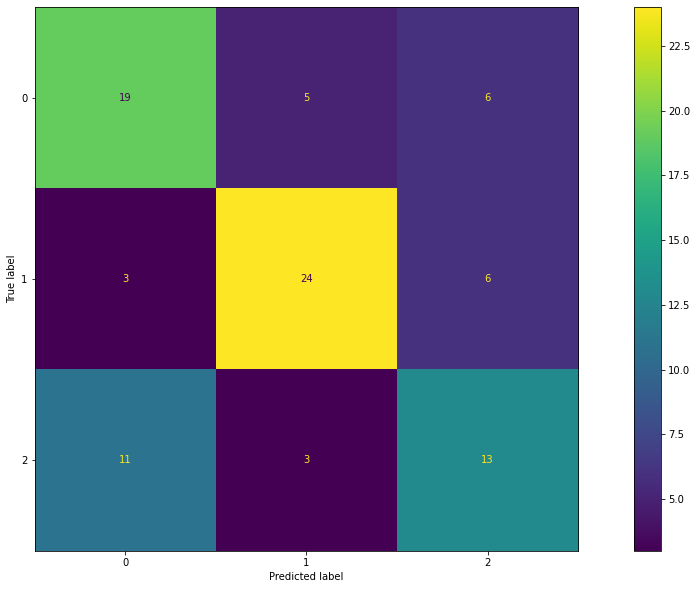

In [29]:
gscv_my_dtc = GridSearchCV(
    Pipeline([("dtc", MyDecisionTreeClassifier(classes=3))]),
    param_grid=params,
    cv=2,
    scoring="accuracy",
)
gscv_my_dtc.fit(train_X, train_y)
scores(gscv_my_dtc, test_X, test_y)

### Сравнение с sklearn

[Decision Tree Classifier](sklearn.tree.DecisionTreeClassifier) из библиотеки scikit-learn

Лучшие гиперпараметры модели: {'dtc__criterion': 'entropy', 'dtc__max_depth': 8, 'dtc__min_samples_split': 2, 'dtc__splitter': 'best'}
Лучший счёт модели: 0.6021436193584835
Метрика Accuracy: 0.5777777777777777


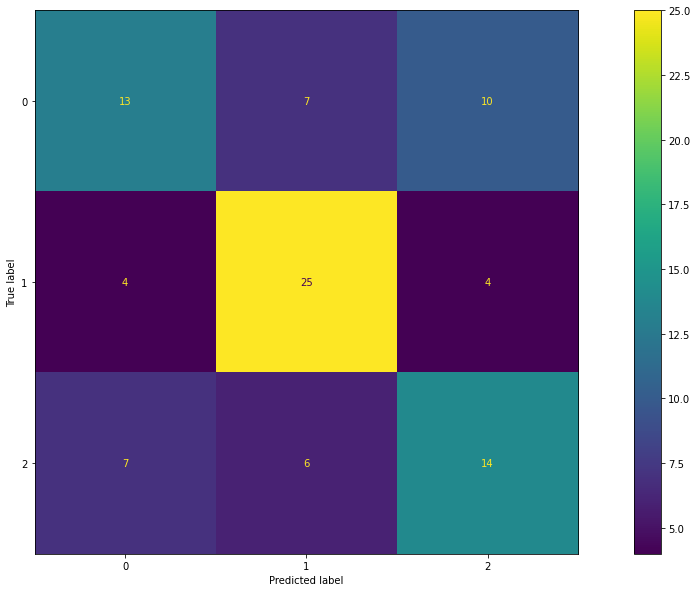

In [30]:
gscv_dtc = GridSearchCV(
    Pipeline([("dtc", DecisionTreeClassifier())]),
    param_grid=params,
    cv=2,
    scoring="accuracy",
)
gscv_dtc.fit(train_X, train_y)
scores(gscv_dtc, test_X, test_y)